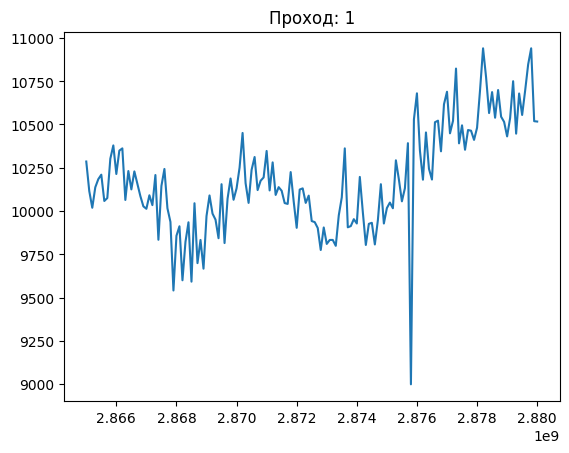

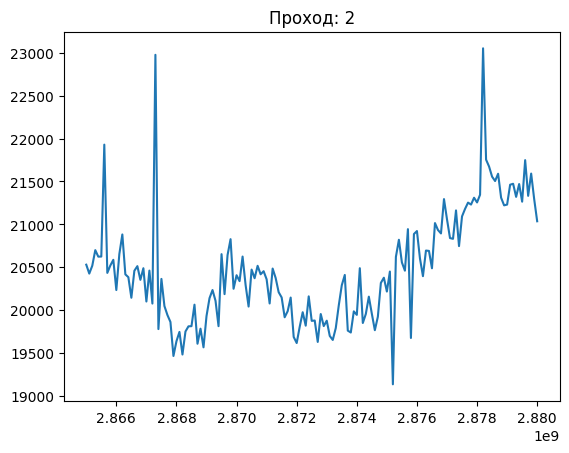

In [ ]:
import numpy as np
import struct
from scapy.sendrecv import sniff
from hardware.spincore import impulse_builder
import time
import matplotlib.pyplot as plt
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)

from pyvisa import ResourceManager

RES = "USB0::0x1AB1::0x099C::DSG3G264300050::INSTR"

start = 2865*1E6
stop = 2880*1E6
step = 100*1E3
gain = -30

rm = ResourceManager()
dev = rm.open_resource(RES)
dev.write(f':LEV {gain}dBm')
dev.write(":OUTP 1")

impulse_builder(
                2,
                [0, 1],
                [1, 1],
                [0, 0],
                [10, 10],
                10,
                int(1E6),
                int(1E6)
            )

frequencies = np.arange(start=start, stop=(stop+step), step=step)

ph = np.zeros(len(frequencies))

ph_tmp = []

def packet_callback(packet):

    global ph_tmp

    if packet.haslayer("Raw"):
        payload = bytes(packet["Raw"].load)[42:]

        if len(payload) < 58:
                    return

        try:
            package_id = struct.unpack('<H', payload[1:3])[0]
            byte6 = struct.unpack('<B', payload[5:6])[0]
            flag_valid = byte6 & 0x1
            flag_pos = (byte6 & 0x10) >> 4
            flag_neg = (byte6 & 0x8) >> 3
            count_pos = int.from_bytes(payload[58:61], byteorder="little")
            count_neg = int.from_bytes(payload[61:63], byteorder="little")

            result = {
                    "package_id": package_id,
                    "flag_valid": flag_valid,
                    "flag_neg": flag_neg,
                    "flag_pos": flag_pos,
                    "count_neg": count_neg,
                    "count_pos": count_pos
            }

            if flag_valid == 1 and flag_pos == 1:
                ph_tmp.append(result["count_pos"])
        except Exception as e:
            pass

c = 0

n_avg = 30

for n in range(n_avg+1):
    for freq in frequencies: 
        dev.write(f':FREQ {freq}')
        time.sleep(0.005)
        #print(dev.query(":FREQ?"))
        while 1:
            sniff(iface="Ethernet", filter="src host 192.168.1.2", prn=packet_callback, timeout=0.045)
            if len(ph_tmp) == 3:
                break
            else:
                ph_tmp = []
        
        ph[c] += round(sum(ph_tmp)/3)
        ph_tmp = []
        c += 1
    c = 0
    if n == n_avg:
         ph = [ph[i]/n_avg for i in range(len(ph))]
    plt.cla()
    plt.plot(frequencies, ph)
    plt.title(f"Проход: {n+1}")
    plt.show()

    
